In [19]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import FileLink
import os
from IPython.display import clear_output, display

import plot

In [20]:
def load_images(filename):
    folder_path = 'data/export/datasets/RoadAnomaly/test/'
    
    original_image_path = folder_path + 'imgs/' + filename
    original_image = cv.imread(original_image_path) 
    assert original_image is not None, "original_gt could not be read, check with os.path.exists()"

    original_gt_path = folder_path + 'gt/' + filename
    original_gt = cv.imread(original_gt_path) 
    assert original_gt is not None, "original_image could not be read, check with os.path.exists()"
    
    return original_image[:,:,[2,1,0]], original_gt


In [21]:
#Load first image and gt
original_image_path = 'data/export/datasets/RoadAnomaly/test/imgs/animals27_wildlife_bear.png'
original_image = cv.imread(original_image_path) 
assert original_image is not None, "original_gt could not be read, check with os.path.exists()"

original_gt_path = 'data/export/datasets/RoadAnomaly/test/gt/animals27_wildlife_bear.png'
original_gt = cv.imread(original_gt_path) 
assert original_gt is not None, "original_image could not be read, check with os.path.exists()"


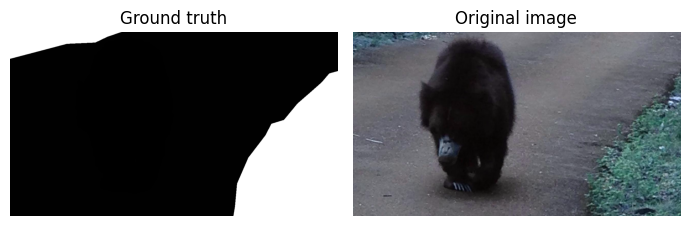

In [22]:
#Image preview

fig, ax = plt.subplots(1, 2, figsize=(7, 3))  # 1 row, 2 columns, and adjust the figure size as needed
# Display the mask
ax[0].imshow(original_gt)
ax[0].set_title('Ground truth')
ax[0].axis('off')  # Hide axes

# Display the image
ax[1].imshow(original_image)
ax[1].set_title('Original image')
ax[1].axis('off')  # Hide axes

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


In [23]:
# Overlay of gt with image
def drawOverlay(opacity):
    obstacle_clr = [255,0,0]
    road_clr = [128,64,128]

    assert original_image.shape[:2] == original_gt.shape[:2], "Images must have the same dimensions"

    # Create masks of gt
    road_mask = (original_gt == 1)
    obstacle_mask = (original_gt == 0)

    # Create a road and anomaly overlays with the same size as the image
    road_overlay = np.zeros_like(original_image)
    road_overlay[:, :] = road_clr

    obstacle_overlay = np.zeros_like(original_image)
    obstacle_overlay[:, :] = obstacle_clr


    #Create colored masks
    road_clr_mask = road_overlay * road_mask
    obstacle_clr_mask = obstacle_overlay * obstacle_mask
    combined_mask = cv.add(road_clr_mask, obstacle_clr_mask)

    if(opacity != 1):
        combined_image = cv.addWeighted(combined_mask, opacity, original_image , 1, 0)
    else:    
        inverted_mask = np.where(combined_mask == 0, 1, 0).astype(np.uint8)
        combined_image = cv.add(combined_mask, inverted_mask * original_image)
    return combined_image

    fig, ax = plt.subplots(1, 4, figsize=(10, 6))
    ax[0].imshow(original_image)
    ax[0].set_title('Original_image')
    ax[0].axis('off') 

    ax[1].imshow(road_clr_mask)
    ax[1].set_title('Colored mask')
    ax[1].axis('off')  

    ax[2].imshow(combined_mask)
    ax[2].set_title('Combined mask')
    ax[2].axis('off')  

    ax[3].imshow(combined_image)
    ax[3].set_title('Combined image')
    ax[3].axis('off')  

    plt.tight_layout()
    plt.show()

In [24]:
def drawContoure():
    road_clr_con = (0,255,0)
    obstacle_clr_con = (255,0,0)
    thickness = 3
    
    # Convert image to grayscale
    imgray = cv.cvtColor(original_gt, cv.COLOR_BGR2GRAY)

    # Apply thresholding
    _, road_thresh = cv.threshold(imgray, 1, 255, 0)
    _, obstacle_thresh = cv.threshold(imgray, 0, 255, 0)

    # FindContours 
    road_contours, _ = cv.findContours(road_thresh, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    obstacle_contours, _ = cv.findContours(obstacle_thresh, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    
    # Draw the contours on the original image (or a copy of it)
    contours_image = original_image.copy()
    cv.drawContours(contours_image, road_contours, -1, road_clr_con, thickness)  
    cv.drawContours(contours_image, obstacle_contours, -1, obstacle_clr_con , thickness)  
    return contours_image

In [25]:
def show_images(original_image, original_gt):
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))  # 1 row, 2 columns, and adjust the figure size as needed
    ax[0].imshow(plot.drawContoure(original_image,original_gt))
    ax[0].set_title('Contoures')
    ax[0].axis('off') 

    ax[1].imshow(plot.drawOverlay(0.5,original_image,original_gt))
    ax[1].set_title('Overlay')
    ax[1].axis('off')  

    ax[2].imshow(plot.drawOverlay(1,original_image,original_gt))
    ax[2].set_title('Overlay opacity 100%')
    ax[2].axis('off')  

    plt.tight_layout()
    plt.show()

    display(uploader_widget)


#    plt.imshow(drawOverlay(1))
#    plt.title("Overlay opacity 100%")
#    plt.axis('off')
#    plt.show()



In [26]:
def on_file_selected(change):
    selected_file = change['new']
    print(f"Selected file: {selected_file}")
    # Call your function with the selected file name here
    original_image,original_gt = load_images(selected_file)
    clear_output(wait=True)  # Clear the previous output
    show_images(original_image, original_gt)

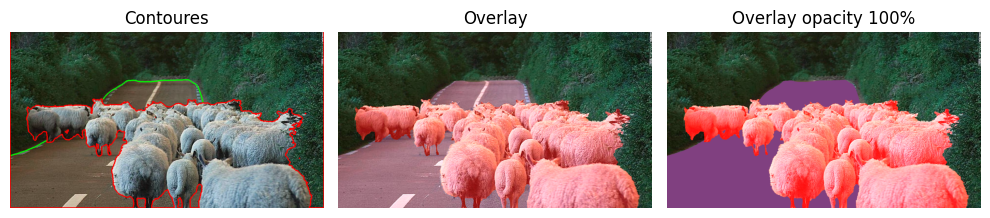

Dropdown(description='Choose preset', index=7, options=('cones08_can.png', 'animals10_bovine_cattle_beside_roa…

In [27]:
uploader_widget = widgets.Dropdown(
    options=plot.get_all_files('data/export/datasets/RoadAnomaly/test/imgs/'),
    description='Choose preset',
    disabled=False,
)
uploader_widget.observe(on_file_selected, names='value')

show_images(original_image, original_gt)
#display(uploader_widget)  # Display the widget initially